## Семинар 2 "Распознавание рукописных цифр"

ФИО: Дорожинский Владислав Игоревич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from copy import deepcopy
from layers import Linear, Sigmoid, NLLLoss
%matplotlib inline

In [2]:
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)

In [37]:
import PIL.Image
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.RandomRotation(5, resample=PIL.Image.BILINEAR),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
transform_test = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('../data/', train=True, download=True, transform=transform)
test_dataset = MNIST('../data/', train=False, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [4]:
## Usage example:
X, y = next(iter(train_loader))
X = X.view(X.size(0), -1)
X = X.numpy()
y = y.numpy()

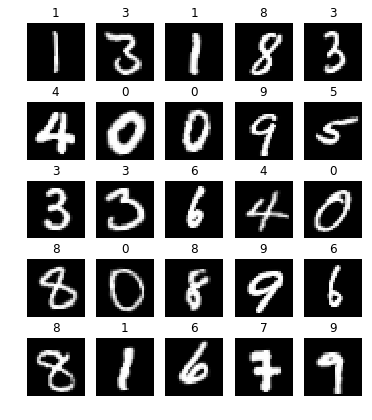

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [6]:
from layers import NeuralNetwork, Sigmoid, Linear, NLLLoss, ReLU, ELU

def train(net, epochs, learning_rate=1e-2, max_jitter=1):
    losses = []
    accs = []
    best_net = None
    best_acc = 0
    try:
        for i in range(epochs):
            nll = NLLLoss()
            for j, (X, y) in enumerate(train_loader):
                X = X.view(X.size(0), -1)
                X = X.numpy()
                y = y.numpy()
                
                # jitter
                X = X.reshape(-1, 28, 28)
                shift_x, shift_y = np.random.randint(-max_jitter, max_jitter + 1, 2)
                X = np.roll(np.roll(X, shift_x, -1), shift_y, -2)
                X = X.reshape(-1, 784)
                
                # train
                y_ = nn.forward(X)
                loss = nll.forward(y_, y)
                dLdy = nll.backward()
                nn.backward(dLdy)
                nn.step(learning_rate)
            loss = 0
            acc = 0
            _n = 0
            for X, y in test_loader:
                X = X.view(X.size(0), -1)
                X = X.numpy()
                y = y.numpy()
                y_ = nn.forward(X)
                acc += np.sum(np.argmax(y_, axis=1) == y)
                loss += nll.forward(y_, y)
                _n += y.shape[0]
            loss /= _n
            acc /= _n
            losses.append(loss)
            accs.append(acc)
            if acc > best_acc:
                best_acc = acc
                best_net = deepcopy(net)
            print('Test at', i, '. Loss:', loss, 'Accuracy:', acc, 'Best:', best_acc)
    except KeyboardInterrupt:
        pass
    return best_net, losses, accs

In [47]:
epochs = 5

nn = NeuralNetwork([
    Linear(784, 100),
    Sigmoid(),
    Linear(100, 100),
    Sigmoid(),
    Linear(100, 10),
])

best_net, losses, accs = train(nn, epochs, learning_rate=1e-3)

Test at 0 . Loss: 0.0031324119544070103 Accuracy: 0.9015 Best: 0.9015
Test at 1 . Loss: 0.0016297502448467654 Accuracy: 0.9462 Best: 0.9462
Test at 2 . Loss: 0.0011660694059628805 Accuracy: 0.9609 Best: 0.9609
Test at 3 . Loss: 0.0009436890094049808 Accuracy: 0.9677 Best: 0.9677
Test at 4 . Loss: 0.0009035394841428257 Accuracy: 0.9692 Best: 0.9692


### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

#### ReLU

In [40]:
epochs = 10

nn = NeuralNetwork([
    Linear(784, 100),
    ReLU(),
    Linear(100, 100),
    ReLU(),
    Linear(100, 10),
])

best_net, losses, accs = train(nn, epochs, learning_rate=1e-3)

Test at 0 . Loss: 0.001806402030464418 Accuracy: 0.9325 Best: 0.9325
Test at 1 . Loss: 0.0010513551046163394 Accuracy: 0.9562 Best: 0.9562
Test at 2 . Loss: 0.0008471832570399569 Accuracy: 0.9677 Best: 0.9677
Test at 3 . Loss: 0.0007856981722861015 Accuracy: 0.9668 Best: 0.9677
Test at 4 . Loss: 0.000598052179975649 Accuracy: 0.9767 Best: 0.9767
Test at 5 . Loss: 0.0005743438098880204 Accuracy: 0.9764 Best: 0.9767
Test at 6 . Loss: 0.0005839231205139264 Accuracy: 0.9732 Best: 0.9767
Test at 7 . Loss: 0.00048334074770171924 Accuracy: 0.9801 Best: 0.9801
Test at 8 . Loss: 0.0004314720858180232 Accuracy: 0.9822 Best: 0.9822
Test at 9 . Loss: 0.0004789553408343993 Accuracy: 0.9799 Best: 0.9822


#### ELU

In [48]:
epochs = 200

nn = NeuralNetwork([
    Linear(784, 200),
    ELU(),
    Linear(200, 150),
    ELU(),
    Linear(150, 60),
    ELU(),
    Linear(60, 10),
])

nn, losses, accs = train(nn, epochs, learning_rate=1e-3)

Test at 0 . Loss: 0.001455041340834527 Accuracy: 0.9421 Best: 0.9421
Test at 1 . Loss: 0.0008572989199685966 Accuracy: 0.9653 Best: 0.9653
Test at 2 . Loss: 0.000631531810659513 Accuracy: 0.9739 Best: 0.9739
Test at 3 . Loss: 0.000591299194026264 Accuracy: 0.9762 Best: 0.9762
Test at 4 . Loss: 0.0005204632662269129 Accuracy: 0.9792 Best: 0.9792
Test at 5 . Loss: 0.000449056911122423 Accuracy: 0.9801 Best: 0.9801
Test at 6 . Loss: 0.00047034963358211543 Accuracy: 0.9809 Best: 0.9809
Test at 7 . Loss: 0.0005457911732202592 Accuracy: 0.9804 Best: 0.9809
Test at 8 . Loss: 0.0004278855396027731 Accuracy: 0.9834 Best: 0.9834
Test at 9 . Loss: 0.00040909293885940575 Accuracy: 0.983 Best: 0.9834
Test at 10 . Loss: 0.0004045386573906753 Accuracy: 0.9848 Best: 0.9848
Test at 11 . Loss: 0.00036346980425312606 Accuracy: 0.9851 Best: 0.9851
Test at 12 . Loss: 0.0003783626356563951 Accuracy: 0.9858 Best: 0.9858
Test at 13 . Loss: 0.00036874753308070035 Accuracy: 0.9865 Best: 0.9865
Test at 14 . Loss

Test at 115 . Loss: 0.0005031619089905534 Accuracy: 0.9866 Best: 0.9894
Test at 116 . Loss: 0.0005864645816400109 Accuracy: 0.987 Best: 0.9894
Test at 117 . Loss: 0.00046520370850983904 Accuracy: 0.9888 Best: 0.9894
Test at 118 . Loss: 0.00047667497758963664 Accuracy: 0.9887 Best: 0.9894
Test at 119 . Loss: 0.000485379847674755 Accuracy: 0.988 Best: 0.9894
Test at 120 . Loss: 0.00043664655154471957 Accuracy: 0.9878 Best: 0.9894
Test at 121 . Loss: 0.0005125633173321585 Accuracy: 0.9879 Best: 0.9894
Test at 122 . Loss: 0.0005850474415074469 Accuracy: 0.9872 Best: 0.9894
Test at 123 . Loss: 0.00043956186249633405 Accuracy: 0.9886 Best: 0.9894
Test at 124 . Loss: 0.0005201261196435087 Accuracy: 0.9878 Best: 0.9894
Test at 125 . Loss: 0.000540370005331912 Accuracy: 0.9877 Best: 0.9894
Test at 126 . Loss: 0.0005451385140457685 Accuracy: 0.9861 Best: 0.9894
Test at 127 . Loss: 0.0004934629621492848 Accuracy: 0.9894 Best: 0.9894
Test at 128 . Loss: 0.00045000843014412936 Accuracy: 0.9889 Best

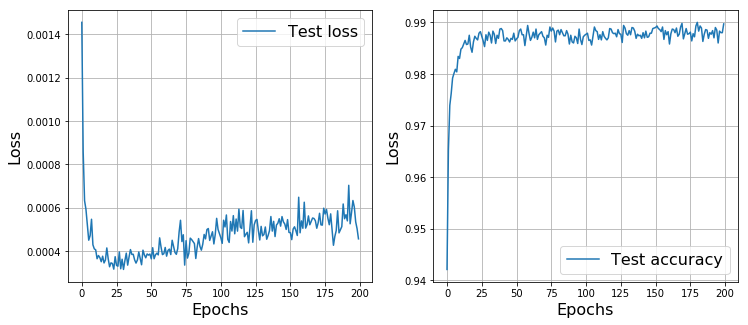

In [56]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Test loss')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.subplot(1, 2, 2)
plt.plot(accs, label='Test accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

### Часть 3: Анализ ошибок

In [54]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = nn.forward(X)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

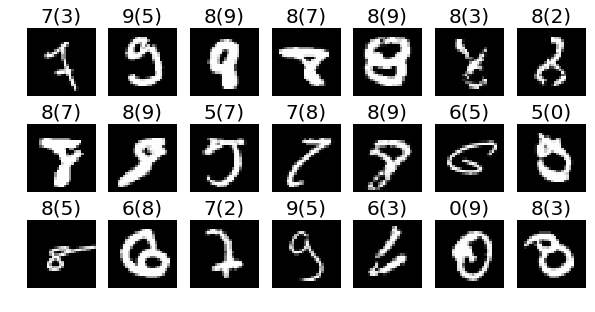

In [55]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

В результате была получена точность в 99.00%$^*$ на тестовой выборке.

Предобработка данных состояла из двух частей: случайного вращения на $5^\circ$ и случайного смещения на 1 пиксель по вертикали и горизонтали. Выбор величины смещения в 1 пиксель обусловлен особенностью датасета MNIST. Каждая картинка уже предобработана таким образом, что ее центр масс смещен в центр изображения. Таким образом неопределенность расположения цифры не превышает 1 пикселя.

Для ускорения сходимости использовался алгоритм Adam с параметрами $lerning\_rate=0.001, \beta_1=0.9, \beta_2=0.999, \varepsilon=10^{-8}$.

В качестве нелинейности использовалась ELU с параметром $ \alpha = 1$, так как она наименее подвержена проблеме затухающих градиентов.

$*$ Из графика для функции потерь видно, что минимум достигается на 25 эпохе, когда точность составляет 98.82%. Именно на такую точность на тестовой выборке стоит рассчитывать при выборе модели по validation set'у.